# Observing Dark Worlds

## Goal:
Observing Dark World is a astrophysics problem of detecting positions of dark matter halos by using its gravitational lensing effect, typically meas it destort the light of background galaxy which passes close to the Dark Matter.
It's a hard problem because detecting dark matter is difficult and it's hard to recognize the distortion.
![Gravitational_Lensing](images/reorderdarkmatter.png)

## Data
To solve the position of the core of dark matter, we gather 300 telescope scan data, each telescope data contains 300 to 800 galaxy data. Each galaxy data are consist of x and y corrdinates and two ellipiticity data, represents the elongation of the galaxies, cased by the spacetime wrap from dark matter halos. (Salimans, 2012)

# imports

In [1]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import edward as ed
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import tensorflow.contrib.distributions as ds
from edward.models import Normal, Uniform, InverseGamma, Empirical, Categorical, Mixture
from tensorflow.contrib import slim
from edward.util import Progbar

# import data
* all_sky_star = []: skies
    * all_sky_star[i]: one sky
        * all_sky_star[i][0]: galaxy name
        * all_sky_star[i][1]: galaxy x position
        * all_sky_star[i][2]: galaxy y position
        * all_sky_star[i][3]: galaxy E1
        * all_sky_star[i][4]: galaxy E2
* all_sky_halo = []:halos
    * all_sky_halo[i] :halo for sky i
        * all_sky_halo[i][0]: sky name
        * all_sky_halo[i][1]: number of halos
        * all_sky_halo[i][2]: halo1 x
        * all_sky_halo[i][3]: halo1 y
        * ...
        * all_sky_halo[i][7]: halo3 y

In [2]:
num_of_sky = 300
file_path = "datasets"
all_sky_star = []

for sky in np.arange(1, num_of_sky + 1, 1):
    sky_path = "Train_Skies/Training_Sky" + str(sky) + ".csv"
    halo_path = "Training_halos.csv"
    star = pd.read_csv(file_path + "/" + sky_path)
    all_sky_star.append(star.values)
star.head()
#all_sky_halo = all_sky_halo.values


,GalaxyID,x,y,e1,e2
0,Galaxy1,1630.16,1027.12,-0.194881,0.045802
1,Galaxy2,1056.72,126.24,-0.235309,0.176257
2,Galaxy3,3903.84,2612.56,0.213914,-0.052132
3,Galaxy4,2120.96,2098.82,0.272938,-0.045578
4,Galaxy5,1549.02,2042.28,-0.507234,0.086598


In [3]:
all_sky_halo_data = pd.read_csv(file_path + "/" + halo_path)
all_sky_halo = all_sky_halo_data.values
all_sky_halo_data.head()


,SkyId,numberHalos,x_ref,y_ref,halo_x1,halo_y1,halo_x2,halo_y2,halo_x3,halo_y3
0,Sky1,1,1086.80,1114.61,1086.80,1114.61,0.0,0.0,0.0,0.0
1,Sky2,1,3477.71,1907.33,3477.71,1907.33,0.0,0.0,0.0,0.0
2,Sky3,1,2315.78,1081.95,2315.78,1081.95,0.0,0.0,0.0,0.0
3,Sky4,1,1408.61,1685.86,1408.61,1685.86,0.0,0.0,0.0,0.0
4,Sky5,1,3091.65,2001.08,3091.65,2001.08,0.0,0.0,0.0,0.0


# data processing
## single_sky_data
* sky_num = []:    No. of test sky
* single_sky_halo_xy: 2d position of halo in test sky
* single_sky_e1[i]:   e1 of i_th galaxy in test sky
* single_sky_e2[i]:   e2 of i_th galaxy in test sky
* single_sky_a1[i]:   a1 of i_th galaxy in test sky
* single_sky_a2[i]:   a2 of i_th galaxy in test sky

In [4]:
sky_num = 2
single_sky_halo_xy = np.array(all_sky_halo[sky_num, 2:4], dtype=np.float32)
single_sky_e1 = np.array(all_sky_star[sky_num][:, 3], dtype=np.float32)
single_sky_e2 = np.array(all_sky_star[sky_num][:, 4], dtype=np.float32)
l2_e1e2 = np.sqrt(single_sky_e1**2 + single_sky_e2**2)
q = ((1. + l2_e1e2) / (1 - l2_e1e2))**2
single_sky_a1 = np.sqrt(q / (1 + q))
single_sky_b1 = np.sqrt(1. / (1 + q))
single_sky_pos_xy = np.array(all_sky_star[sky_num][:, 1:3])
num_of_glxy = single_sky_pos_xy.shape[0]

# distribution check

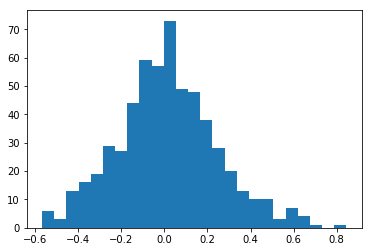

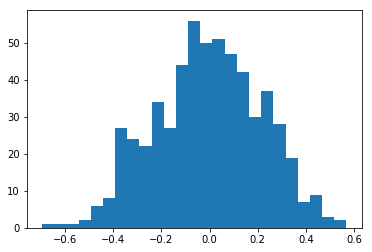

In [5]:
plt.clf()
plt.hist(single_sky_e1,25)
plt.show()
plt.hist(single_sky_e2,25)
plt.show()

# tangential funtion

In [6]:
def tangential(glxy_position, halo_position, axis):
    delta = glxy_position - halo_position
    t = 2 * tf.atan2(delta[:, 1], delta[:, 0])
    return -tf.cos(t) if axis == 0 else -tf.sin(t)

# Model 1

In [179]:
N = num_of_glxy
glxy_pos_xy = tf.placeholder(tf.float32, [N, 2])
# halo_pos_xy = Uniform(low=[0.,0.],high=[4200., 4200.])
halo_pos_xy = Normal(loc=tf.constant([2100., 2100.]), scale=tf.constant(20.0))
sigma = tf.constant(.05)  # InverseGamma(20.0, 1.0)
l2diff_halo_glxy = tf.sqrt(tf.reduce_sum(tf.square(glxy_pos_xy - halo_pos_xy),
                           reduction_indices=1))
sess = ed.get_session()
glxy_e1 = Normal(loc=tangential(glxy_pos_xy, halo_pos_xy, 0), scale=sigma)
glxy_e2 = Normal(loc=tangential(glxy_pos_xy, halo_pos_xy, 1), scale=sigma)

# Inference

## Variational Inference

In [363]:
def normal_qx():
    return Normal(tf.random_normal([2], mean=2100.), scale=tf.nn.softplus(
                  tf.Variable(tf.random_normal([2]))))


e1_in = single_sky_e1.reshape(N).tolist()
e2_in = single_sky_e2.reshape(N).tolist()
q_halo_pos_xy = normal_qx()
inference = ed.KLqp({halo_pos_xy: q_halo_pos_xy},
                    data={glxy_pos_xy: single_sky_pos_xy,
                    glxy_e1: e1_in, glxy_e2: e2_in})
inference.run(n_iter=10000, n_samples=10)

ValueError: cannot reshape array of size 578 into shape (160842,)

# MCMC

In [181]:
# Inference
def constraints_normal(T):
    return tf.minimum(tf.maximum(tf.Variable(tf.random_normal([T, 2],
                      mean=[2100., 2100.], stddev=100.)), 0), 4200)
e1_in = single_sky_e1.reshape(N).tolist()
e2_in = single_sky_e2.reshape(N).tolist()

T = 1000
q_halo_pos_xy = Empirical(params=constraints_normal(T))
# qsig = Empirical(params=tf.Variable(tf.zeros(10000)))
inference = ed.SGHMC({halo_pos_xy: q_halo_pos_xy},
                     data={glxy_pos_xy: single_sky_pos_xy,
                     glxy_e1: e1_in, glxy_e2: e2_in})
inference.run(step_size=15.)

1000/1000 [100%] ██████████████████████████████ Elapsed: 13s | Acceptance Rate: 1.001


# Criticism

[ 2336.63208008  1216.4543457 ] [  19.40271568  112.43242645]


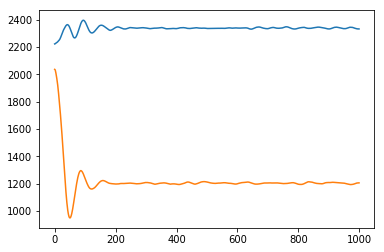

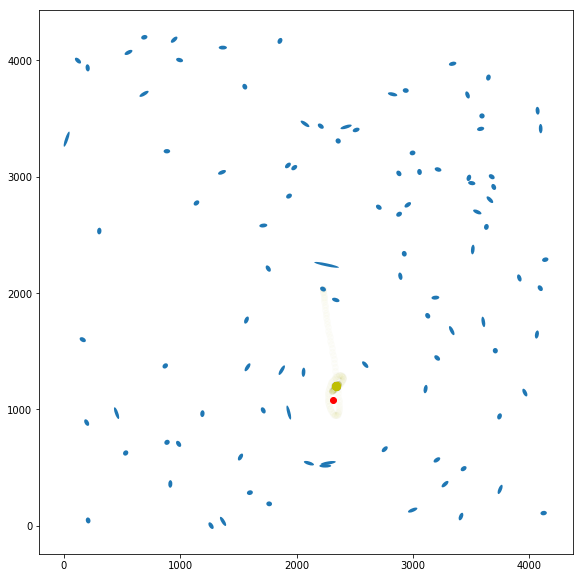

In [183]:
def draw_sky(galaxies):
    """adapted from Vishal Goklani"""
    size_multiplier = 45
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, aspect='equal')
    n = galaxies.shape[0]
    for i in range(n):
        _g = galaxies[i, :]
        x, y = _g[0], _g[1]
        d = np.sqrt(_g[2]**2 + _g[3]**2)
        a = 1.0 / (1 - d)
        b = 1.0 / (1 + d)
        theta = np.degrees(np.arctan2(_g[3], _g[2]) * 0.5)
        ax.add_patch(Ellipse(xy=(x, y), width=size_multiplier * a,
                     height=size_multiplier * b, angle=theta))
    ax.autoscale_view(tight=True)
    return fig

mean, stddev = sess.run([q_halo_pos_xy.mean(), q_halo_pos_xy.stddev()])
print(mean, stddev)
samples = sess.run(q_halo_pos_xy.params)
# plt.hist(samples, bins='auto')
# plt.show()

# Trace plot.
plt.plot(samples)
plt.show()
plt.clf()
fig = draw_sky(all_sky_star[sky_num][:100, 1:])
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.015, c="y")
plt.scatter(all_sky_halo[sky_num, 2], all_sky_halo[sky_num, 3], c="r")
plt.show()


# Criticism 2
Test if the model stuck in local minimas by randomize starting point

3000/3000 [100%] ██████████████████████████████ Elapsed: 10s | Acceptance Rate: 1.000
[ 2243.95556641  1138.13537598] [ 358.6701355  227.1583252]
3000/3000 [100%] ██████████████████████████████ Elapsed: 9s | Acceptance Rate: 1.000
[ 2275.77124023  1210.63464355] [ 298.45257568   31.00737572]
3000/3000 [100%] ██████████████████████████████ Elapsed: 8s | Acceptance Rate: 1.000
[ 2257.42456055  1261.59765625] [ 337.16680908  220.67985535]
3000/3000 [100%] ██████████████████████████████ Elapsed: 9s | Acceptance Rate: 1.000
[  905.04266357  3163.9597168 ] [ 81.71781158  67.2808075 ]
3000/3000 [100%] ██████████████████████████████ Elapsed: 10s | Acceptance Rate: 1.000
[ 2322.36425781  1184.95324707] [ 111.49421692  114.19600677]
3000/3000 [100%] ██████████████████████████████ Elapsed: 11s | Acceptance Rate: 1.000
[ 2325.65600586  1207.46240234] [ 105.15981293   25.94026184]
3000/3000 [100%] ██████████████████████████████ Elapsed: 9s | Acceptance Rate: 1.000
[ 2314.50268555  1234.7565918 ] [ 

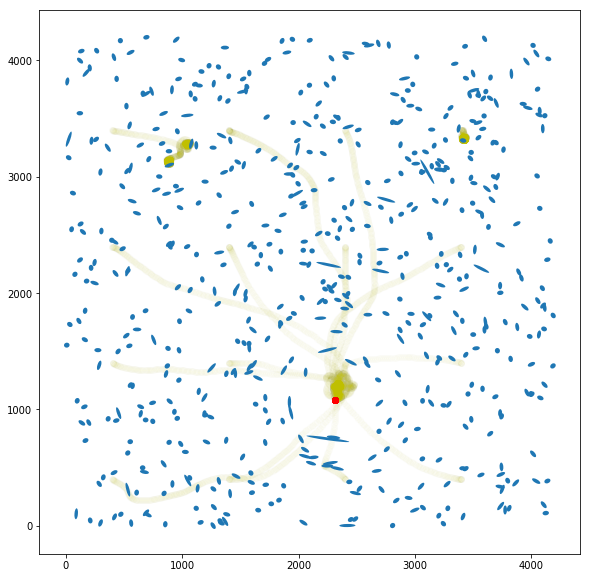

In [143]:
plt.clf()
fig = draw_sky(all_sky_star[sky_num][:, 1:])
for i in np.arange(400, 4001, 1000):
    for j in np.arange(400, 4001, 1000):
        def constraints_normal(T):
            return tf.minimum(tf.maximum(tf.Variable(tf.random_normal(
                              [T, 2], mean=[i, j], stddev=1.)), 0), 4200)

        T = 3000
        q_halo_pos_xy = Empirical(params=constraints_normal(T))
        # qsig = Empirical(params=tf.Variable(tf.zeros(10000)))
        inference = ed.SGHMC({halo_pos_xy: q_halo_pos_xy},
                             data={glxy_pos_xy: single_sky_pos_xy,
                             glxy_e1: e1_in, glxy_e2: e2_in})
        inference.run(step_size=5.)

        mean, stddev = sess.run([q_halo_pos_xy.mean(), q_halo_pos_xy.stddev()])
        print(mean, stddev)
        samples = sess.run(q_halo_pos_xy.params)
        # plt.hist(samples, bins='auto')
        # plt.show()

        # Trace plot.
        # plt.plot(samples)
        # plt.show()

        plt.scatter(samples[0:, 0], samples[0:, 1], alpha=0.015, c="y")
        plt.scatter(all_sky_halo[sky_num, 2], all_sky_halo[sky_num, 3], c="r")
plt.show()


# Neural Network for distance funtion

## concatnate data

In [364]:
all_sky_glxy_no = [0]
sky0_e1 = np.array(all_sky_star[0][:, 3], dtype=np.float32)
sky0_e2 = np.array(all_sky_star[0][:, 4], dtype=np.float32)
sq = np.sqrt(sky0_e1**2 + sky0_e2**2)
q = ((1. + sq) / (1 - sq))**2
sky0_a1 = np.sqrt(q / (1 + q))
sky0_b1 = np.sqrt(1. / (1 + q))
select = sky0_a1 / sky0_b1 > 2
select = select.reshape(select.shape[0])

conc_glxy_xy = all_sky_star[0][select, 1:3]
conc_halo_xy = np.ones(all_sky_star[0][select, 1:3]
                       .shape) * all_sky_halo[0, 2:4]
conc_glxy_e1_e2 = all_sky_star[0][select, 3:5]
all_sky_glxy_no.append(conc_glxy_xy.shape[0])

for sky2 in np.arange(1, 300, 1):
    e1 = np.array(all_sky_star[sky2][:, 3:4], dtype=np.float32)
    e2 = np.array(all_sky_star[sky2][:, 4:5], dtype=np.float32)
    sq = np.sqrt(e1**2 + e2**2)
    q = ((1. + sq) / (1 - sq))**2
    a1 = np.sqrt(q / (1 + q))
    b1 = np.sqrt(1. / (1 + q))
    select = a1 / b1 > 2
    select = select.reshape(select.shape[0])
    conc_glxy_xy = np.concatenate((conc_glxy_xy, all_sky_star[sky2]
                                  [select, 1:3]), axis=0)
    conc_glxy_e1_e2 = np.concatenate((conc_glxy_e1_e2, all_sky_star[sky2]
                                     [select, 3:5]), axis=0)
    conc_halo_xy = np.concatenate((conc_halo_xy, np.ones(all_sky_star[sky2]
                                   [select, 1:3].shape) *
                                   all_sky_halo[sky2, 2:4]), axis=0)
    all_sky_glxy_no.append(conc_glxy_xy.shape[0])
print(conc_glxy_xy.shape)
print(conc_halo_xy.shape)
print(conc_glxy_e1_e2.shape)
num_all_glxy = conc_glxy_xy.shape[0]
print(all_sky_glxy_no)

(50845, 2)
(50845, 2)
(50845, 2)


# NN model

In [7]:
N = num_all_glxy
glxy_pos_xy = tf.placeholder(tf.float32, [N, 2])
# halo_pos_xy = Uniform(low=[0.,0.],high=[4200., 4200.])
halo_pos_xy = tf.placeholder(tf.float32, [N, 2])
# halo_pos_xy = [2315.61, 1082.86]
# m = Uniform(low=10.,high=1000.)
m = 100

l2diff = tf.sqrt(tf.reduce_sum(tf.square(glxy_pos_xy - halo_pos_xy),
                 reduction_indices=1)) / 4200.

sess = ed.get_session()

w0 = Normal(loc=tf.zeros(1), scale=tf.ones(1))
b0 = Normal(loc=tf.zeros(1), scale=tf.ones(1))
w1 = Normal(loc=tf.zeros(1), scale=tf.ones(1))
# b1 = Normal(loc=tf.zeros(1), scale=tf.ones(1))
w2 = Normal(loc=tf.zeros(1), scale=tf.ones(1))
# b2 = Normal(loc=tf.zeros(1), scale=tf.ones(1))
# b3 = Normal(loc=tf.zeros(1), scale=tf.ones(1))
y = Normal(loc=(tf.multiply(l2diff**(-1), w0) + tf.multiply(l2diff**(1), w1) +
           tf.multiply(l2diff**(2), w2) + b0), scale=tf.ones(N))
mu = y

e1_var = tf.multiply(tangential(glxy_pos_xy, halo_pos_xy, 0), mu)
e2_var = tf.multiply(tangential(glxy_pos_xy, halo_pos_xy, 1), mu)
sess2 = tf.Session()

# inference for NN

In [116]:
e1_in = conc_glxy_e1_e2[:, 0].reshape(N).tolist()
e2_in = conc_glxy_e1_e2[:, 1].reshape(N).tolist()

qw0 = Normal(loc=tf.Variable(tf.random_normal([1])),
             scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
qb0 = Normal(loc=tf.Variable(tf.random_normal([1])),
             scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
qw1 = Normal(loc=tf.Variable(tf.random_normal([1])),
             scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
qb1 = Normal(loc=tf.Variable(tf.random_normal([1])),
             scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
qw2 = Normal(loc=tf.Variable(tf.random_normal([1])),
             scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
qb2 = Normal(loc=tf.Variable(tf.random_normal([1])),
             scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
qb3 = Normal(loc=tf.Variable(tf.random_normal([1])),
             scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

inference = ed.KLqp({w0: qw0, b0: qb0, w1: qw1, w2: qw2},
                    data={halo_pos_xy: conc_halo_xy, glxy_pos_xy: conc_glxy_xy,
                    e1_var: e1_in, e2_var: e2_in})
inference.run(n_samples=5, n_iter=1000)

1000/1000 [100%] ██████████████████████████████ Elapsed: 11s | Loss: -0.000


# check if the weights updated

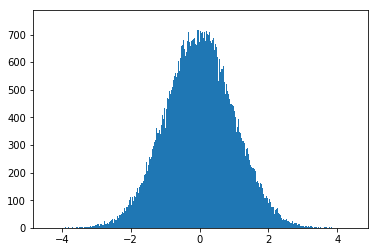

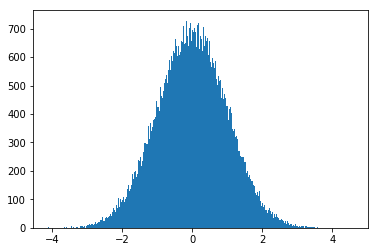

Tensor("Mul_61:0", shape=(50845,), dtype=float32)


In [117]:
w_samples = qw2.sample(100000)[:, 0].eval()
plt.hist(w_samples, 500)
plt.show()
w_samples = w2.sample(100000)[:, 0].eval()
plt.hist(w_samples, 500)
plt.show()
print(e1_var)

# MDN model 

## data convert

In [162]:
all_sky_xy_e1e2 = np.concatenate((conc_glxy_xy / 4200., conc_glxy_e1_e2),
                                 axis=1)
conc_glxy_halo_d_xy = (conc_glxy_xy - conc_halo_xy) / 4200.
all_sky_glxy_halo_r = (np.sum(conc_glxy_halo_d_xy**2, axis=1))**(1 / 2.)
# all_sky_glxy_halo_p = np.arctan2(conc_glxy_halo_d_xy[:,0]
#                                  .astype(dtype = np.float64),
#                                  conc_glxy_halo_d_xy[:,1]
#                                  .astype(dtype = np.float64))
all_sky_glxy_halo_p = np.arctan(conc_glxy_halo_d_xy[:, 1]
                                .astype(dtype=np.float64) /
                                conc_glxy_halo_d_xy[:, 0].
                                astype(dtype=np.float64))
print(all_sky_glxy_halo_p)

[ 1.21057721 -1.36015632 -0.4846697  ..., -1.40583051  0.9180103
  1.36840944]


## sub sampling

(160842, 6)
(3563, 6)
(5604, 6)
(7280, 6)
(8552, 6)
(9674, 6)
(10508, 6)
(11039, 6)
(11453, 6)
(11514, 6)
(11497, 6)
(10831, 6)
(10168, 6)
(9297, 6)
(8473, 6)
(7434, 6)
(6444, 6)
(5429, 6)
(3979, 6)
(2815, 6)
(1768, 6)
(200021, 6)


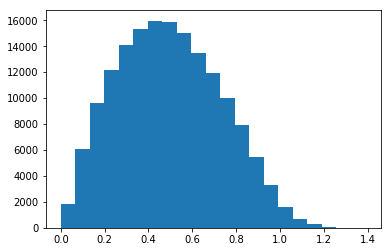

In [365]:
all_sky_xy_e1e2_r_p = np.concatenate((all_sky_xy_e1e2, all_sky_glxy_halo_r
                                     .reshape(all_sky_glxy_halo_r.shape[0],
                                      1)), axis=1)
all_sky_xy_e1e2_r_p = np.concatenate((all_sky_xy_e1e2_r_p, all_sky_glxy_halo_p
                                     .reshape(all_sky_glxy_halo_p.shape[0],
                                      1)), axis=1)
print(all_sky_xy_e1e2_r_p.shape)
# for i np.arange(0,)
ll = all_sky_xy_e1e2_r_p[0].reshape(1, 6)
select = all_sky_xy_e1e2_r_p[:, 4] < 200 / 4200.
for i in np.arange(240, 4200, 200):
    select_low = all_sky_xy_e1e2_r_p[:, 4] > (i / 4200.)
    select_hi = all_sky_xy_e1e2_r_p[:, 4] < (i + 200) / 4200.
    select = select_low & select_hi
    sample = all_sky_xy_e1e2_r_p[select]
    l2 = sample[0].reshape(1, 6)
    for j in range(5000):
        ran = np.random.randint(0, sample.shape[0])
        sam = sample[ran]
        if sam[5] > 0:
            l2 = np.concatenate((l2, sam.reshape(1, 6)))
            sam[5] = sam[5] - np.pi
            l2 = np.concatenate((l2, sam.reshape(1, 6)))
        else:
            l2 = np.concatenate((l2, sam.reshape(1, 6)))
            sam[5] = sam[5] + np.pi
            l2 = np.concatenate((l2, sam.reshape(1, 6)))
    ll = np.concatenate((ll, l2))
    print(sample.shape)
# test = all_sky_xy_e1e2_r_p[select]
print(ll.shape)
# print(test.shape)
plt.hist(all_sky_glxy_halo_r.tolist(), 21)
plt.show()

sample_all_sky_xy_e1e2 = ll[:, :4]
sample_all_sky_glxy_halo_r = ll[:, 4]
sample_all_sky_glxy_halo_p = ll[:, 5]

# sample_all_sky_xy_e1e2 = np.concatenate((sample_all_sky_xy_e1e2,
#                                          sample_all_sky_xy_e1e2))
# sample_all_sky_glxy_halo_r = np.concatenate((sample_all_sky_glxy_halo_r,
#                                              sample_all_sky_glxy_halo_r))
# sample_all_sky_glxy_halo_p = np.concatenate((sample_all_sky_glxy_halo_p,
#                                              np.mod((sample_all_sky_glxy
#                                              _halo_p+(np.pi)),np.pi)))
# print(sample_all_sky_xy_e1e2.shape)

In [214]:
# plt.hist(sample_all_sky_glxy_halo_r.tolist(),21)
# plt.show()
# plt.hist(all_sky_glxy_halo_r.tolist(),21)
# plt.show()
print(ll[500:])

[[0.6553595238095239 0.6313309523809524 0.103523 0.161687
  0.07070694350210896 -0.6690823121134556]
 [0.6553595238095239 0.6313309523809524 0.103523 0.161687
  0.07070694350210896 2.4725103414763376]
 [0.7901095238095238 0.4781785714285714 -0.132176 0.057445
  0.08880839128602534 -1.0029608558929313]
 ..., 
 [0.9944357142857143 0.12319285714285713 -0.290417 0.019842
  1.0034998259605967 -0.6105257581989423]
 [0.43324761904761905 0.9706571428571429 0.037739 0.079696
  0.9808312077378872 -1.2467413212485887]
 [0.43324761904761905 0.9706571428571429 0.037739 0.079696
  0.9808312077378872 1.8948513323412044]]


In [215]:
def neural_network(input_x):
    hidden1 = slim.fully_connected(input_x, 200)
    hidden2 = slim.fully_connected(hidden1, 50)
#     locs_r = slim.fully_connected(hidden2, K, activation_fn=None)
#     scales_r = slim.fully_connected(hidden2, K, activation_fn=tf.exp)
#     logits_r = slim.fully_connected(hidden2, K, activation_fn=None)
    locs_p = slim.fully_connected(hidden2, K, activation_fn=None)
    scales_p = slim.fully_connected(hidden2, K, activation_fn=tf.exp)
    logits_p = slim.fully_connected(hidden2, K, activation_fn=None)
    # return locs_r, scales_r, logits_r, locs_p, scales_p, logits_p
    return locs_p, scales_p, logits_p


N = num_all_glxy
in_data = tf.placeholder(tf.float32, [None, 4], name="in")
out_r = tf.placeholder(tf.float32, [None])
out_p = tf.placeholder(tf.float32, [None])


K = 4

# locs_r, scales_r, logits_r,
locs_p, scales_p, logits_p = neural_network(in_data)
# cat_r = Categorical(logits=logits_r)
# components_r = [Normal(loc=loc, scale=scale) for loc, scale
#               in zip(tf.unstack(tf.transpose(locs_r)),
#                      tf.unstack(tf.transpose(scales_r)))]
# r = Mixture(cat=cat_r, components=components_r, value=tf.zeros_like(out_r))
cat_p = Categorical(logits=logits_p)
cat_p = Categorical(logits=logits_p)
components_p = [Normal(loc=loc, scale=scale) for loc, scale
                in zip(tf.unstack(tf.transpose(locs_p)),
                tf.unstack(tf.transpose(scales_p)))]
p = Mixture(cat=cat_p, components=components_p, value=tf.zeros_like(out_p))

# inference iv

In [216]:
# inference = ed.MAP(data={r: out_r, p:out_p})
inference = ed.MAP(data={p: out_p})
optimizer = tf.train.AdamOptimizer(5e-3)
inference.initialize(optimizer=optimizer, var_list=tf.trainable_variables())

sess = ed.get_session()
tf.global_variables_initializer().run()

In [217]:
# train on only p
n_epoch = 300
train_loss = np.zeros(n_epoch)
test_loss = np.zeros(n_epoch)
for i in range(n_epoch):
    info_dict = inference.update(feed_dict={in_data: sample_all_sky_xy_e1e2,
                                 out_p: sample_all_sky_glxy_halo_p})
    train_loss[i] = info_dict['loss']
    # test_loss[i] = sess.run(inference.loss, feed_dict={in_data:
    #                         sample_all_sky_xy_e1e2,
    #                          out_p: sample_all_sky_glxy_halo_p })
    inference.print_progress(info_dict)

 300/1000 [ 30%] █████████                      ETA: 823s | Loss: 328726.219

In [18]:
n_epoch = 300
train_loss = np.zeros(n_epoch)
test_loss = np.zeros(n_epoch)
for i in range(n_epoch):
    info_dict = inference.update(feed_dict={in_data: all_sky_xy_e1e2,
                                 out_r: all_sky_glxy_halo_r,
                                 out_p: all_sky_glxy_halo_p})
    train_loss[i] = info_dict['loss']
    test_loss[i] = sess.run(inference.loss, feed_dict={in_data:
                            all_sky_xy_e1e2, out_r: all_sky_glxy_halo_r,
                            out_p: all_sky_glxy_halo_p})
    inference.print_progress(info_dict)

 300/1000 [ 30%] █████████                      ETA: 596s | Loss: 74165.297

In [13]:
# train on resampled data
n_epoch = 300
train_loss = np.zeros(n_epoch)
test_loss = np.zeros(n_epoch)
for i in range(n_epoch):
    info_dict = inference.update(feed_dict={in_data: sample_all_sky_xy_e1e2,
                                 out_r: sample_all_sky_glxy_halo_r, out_p:
                                 sample_all_sky_glxy_halo_p})
    train_loss[i] = info_dict['loss']
    test_loss[i] = sess.run(inference.loss, feed_dict={in_data:
                            sample_all_sky_xy_e1e2, out_r:
                            sample_all_sky_glxy_halo_r, out_p:
                            sample_all_sky_glxy_halo_p})
    inference.print_progress(info_dict)

 300/1000 [ 30%] █████████                      ETA: 595s | Loss: 74545.562

In [23]:
# train on near data
n_epoch = 300
train_loss = np.zeros(n_epoch)
test_loss = np.zeros(n_epoch)
select = all_sky_glxy_halo_r < 1500 / 4200.
near_all_sky_xy_e1e2 = all_sky_xy_e1e2[select, :]
near_all_sky_glxy_halo_r = all_sky_glxy_halo_r[select]
near_all_sky_glxy_halo_p = all_sky_glxy_halo_p[select]
for i in range(n_epoch):
    info_dict = inference.update(feed_dict={in_data: near_all_sky_xy_e1e2,
                                 out_r: near_all_sky_glxy_halo_r,
                                 out_p: near_all_sky_glxy_halo_p})
    train_loss[i] = info_dict['loss']
    inference.print_progress(info_dict)
# print(near_all_sky_xy_e1e2)

 300/1000 [ 30%] █████████                      ETA: 226s | Loss: 857.734 

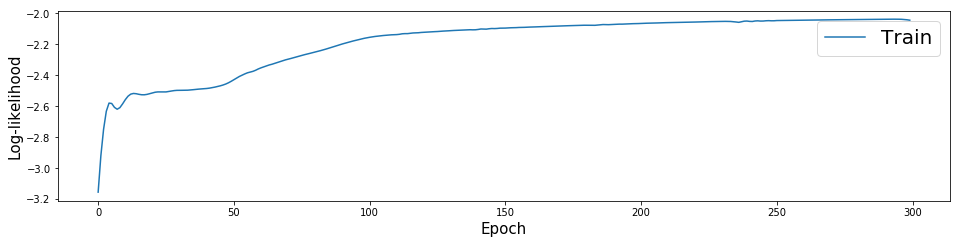

In [218]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
# plt.plot(np.arange(n_epoch), -test_loss , label='Test')
plt.plot(np.arange(n_epoch), -train_loss / N, label='Train')
plt.legend(fontsize=20)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Log-likelihood', fontsize=15)
plt.show()

In [252]:
feed_dat = all_sky_xy_e1e2[all_sky_glxy_no[2]: all_sky_glxy_no[3], :]
select = (feed_dat[:, 2]**2 + feed_dat[:, 3]**2) > 1 / 15.
select2 = all_sky_glxy_halo_r[all_sky_glxy_no[2]:all_sky_glxy_no[3]] < 0.2

print(select2.shape)
# print(select)
feed_dat_sel = feed_dat[select]
print(feed_dat_sel.shape)
# print(feed_dat_sel)
pred_weights_p, pred_means_p, pred_std_p = sess.run(
    [tf.nn.softmax(logits_p), locs_p, scales_p],
    feed_dict={in_data: feed_dat_sel})
# print(feed_dat*4200)
# print(all_sky_xy_e1e2*4200.)
# print(all_sky_xy_e1e2[all_sky_glxy_no[2]]*4200.)
# print(all_sky_xy_e1e2[2]*4200.)
# print(all_sky_glxy_no[1])


(578,)
(313, 4)


In [253]:
pred_weights_r.shape[0]
# r_list = []
pbar = Progbar(300)
# for i in range(300):
#     pbar.update(i)
#     components_r = [Normal(loc=loc, scale=scale) for loc, scale
#                     in zip(tf.unstack(tf.transpose(pred_means_r[i])),
#                      tf.unstack(tf.transpose(pred_std_r[i])))]
#     cat_r = Categorical(logits=pred_weights_r[i])
#     r = Mixture(cat=cat_r, components=components_r, value=tf.zeros_like(out_r[i]))
#     r_list.append(r)
# logprob = 0.
# r.prob(1.).eval()
pred_weights_p.shape[0]
p_list = []
for i in range(300):
    pbar.update(1+i)
    components_p = [Normal(loc=loc, scale=scale) for loc, scale
                    in zip(tf.unstack(tf.transpose(pred_means_p[i])),
                     tf.unstack(tf.transpose(pred_std_p[i])))]
    cat_p = Categorical(logits=pred_weights_p[i])
    p= Mixture(cat=cat_p, components=components_p, value=tf.zeros_like(out_p[i]))
    p_list.append(p)


300/300 [100%] ██████████████████████████████ Elapsed: 44s


In [170]:
def r_t_glxy_halo(glxy_xy,halo_xy):
    extended_halo_xy = np.ones(glxy_xy.shape)*halo_xy
    distance = glxy_xy-halo_xy
    r = (np.sum(distance**2,axis = 1))**(1/2.)
    p = np.arctan((distance[:,0]/distance[:,1]).astype(dtype = np.float64))
    return r,p
print(r_t_glxy_halo(np.array([[1.,1.],[1.,2.],[2.,2.]]),np.array([0.,0.])))

(array([ 1.41421356,  2.23606798,  2.82842712]), array([ 0.78539816,  0.46364761,  0.78539816]))


(126,) (126,)


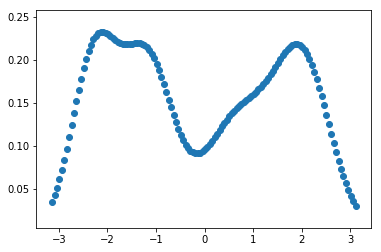

[[2272.28 540.04 2618.931 902.9118]
 [3553.64 2697.71 1190.8134 -1267.8539999999998]
 [1366.51 4110.3 1523.004 -2.3855999999999997]
 ..., 
 [529.32 2188.21 -1761.9546 1241.2764000000002]
 [2041.51 27.47 768.8267999999999 -1676.2284]
 [840.08 532.86 -510.17820000000006 -1549.1742000000002]]


In [257]:
g = 19
a = np.arange(-3.14,3.14,0.05)
b = p_list[g].prob(a.tolist()).eval()
print(a.shape, b.shape)
plt.scatter(a.tolist(), b.tolist())
plt.show()
s = all_sky_xy_e1e2[all_sky_glxy_no[2]:all_sky_glxy_no[3]]
print(feed_dat_sel[:]*4200.)
# print(r_list[0].prob(1. ).eval())

In [ ]:
print(r_list[1].prob([[0.1,0.2],[0.3,0.4]]).eval())

In [293]:
def create_grid(halo_step):
    l = []
    for i in np.arange(int(halo_step/2), 4200, halo_step):
        l2 = []
        for j in np.arange(int(halo_step/2), 4200, halo_step):
            l2.append([i,j])
        l.append(l2)
    return l
grid_20 = np.array(create_grid(20))
dis = np.array(create_grid(20))

def grid_glxy_l2diff(grid, glxy_xy):
    distance = grid - glxy_xy
    l2diff_mat = (np.sum(distance**2,axis=2))**(1/2)
    return l2diff_mat

def grid_glxy_arctan(grid, glxy_xy):
    distance = grid - glxy_xy
    return np.arctan((distance[:,:,1]/distance[:,:,0]).astype(dtype = np.float64))

def grid_glxy_arctan2(grid, glxy_xy):
    distance = grid - glxy_xy
    return np.arctan2(distance[:,:,1].astype(dtype = np.float64),distance[:,:,0].astype(dtype = np.float64))


ata = grid_glxy_arctan(grid_20, [0., 0.])
print(ata.shape)

(210, 210)


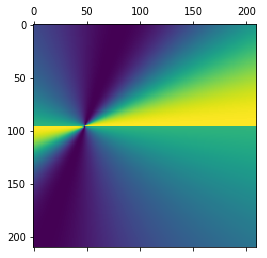

[2426.13 3428.89]


In [362]:
g = 16
dis = grid_glxy_l2diff(grid_20, feed_dat[g,0:2])/4200.
#atan = grid_glxy_arctan(grid_20, all_sky_star[2][g][1:3])
atan = grid_glxy_arctan(grid_20, feed_dat[g,0:2]*4200)
b2d = r_list[g].prob(dis.tolist()).eval()
c2d = p_list[g].prob(atan.tolist()).eval()
#print(a.shape, b.shape)
plt.matshow(c2d)
#plt.savefig("what.pdf")
plt.show()
#print(all_sky_star[2][g][1:3])
print(feed_dat_sel[g,0:2]*4200.)

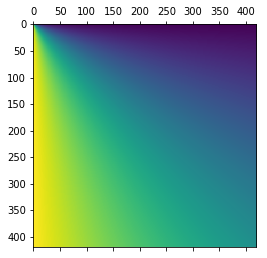

In [136]:
plt.clf()
plt.matshow(ata)
plt.show()

  0/300 [  0%]                                ETA: 0s

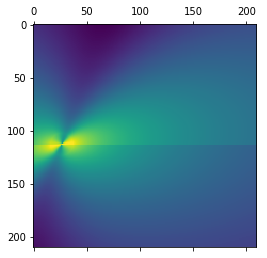

2395.7
357
  1/300 [  0%]                                ETA: 4709s

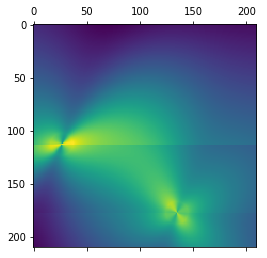

2355.7
777
  2/300 [  0%]                                ETA: 4486s

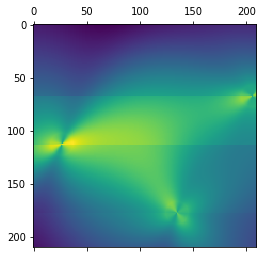

2355.7
777
  3/300 [  1%]                                ETA: 4468s

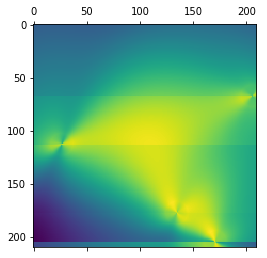

4111.6
3486
  4/300 [  1%]                                ETA: 4392s

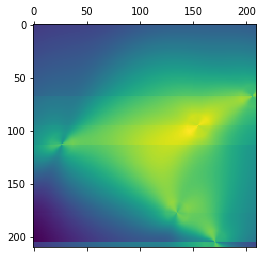

2135.5
3045
  5/300 [  1%]                                ETA: 4375s

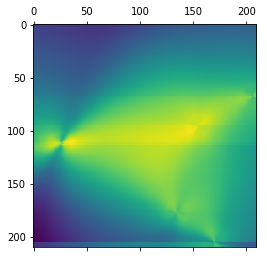

2334.6
756
  6/300 [  2%]                                ETA: 4412s

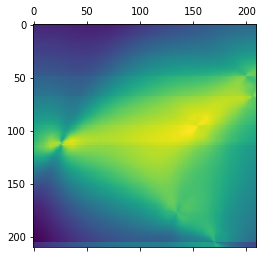

2114.5
3045
  7/300 [  2%]                                ETA: 4392s

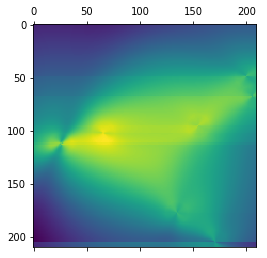

2337.8
1428
  8/300 [  2%]                                ETA: 4341s

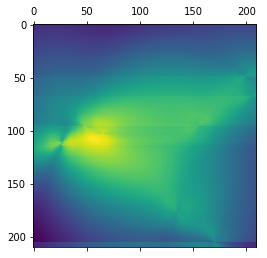

2315.8
1218
  9/300 [  3%]                                ETA: 4324s

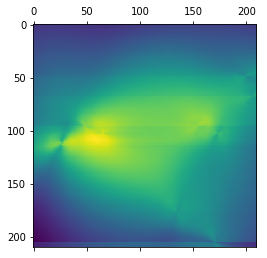

2315.8
1218
 10/300 [  3%] █                              ETA: 4314s

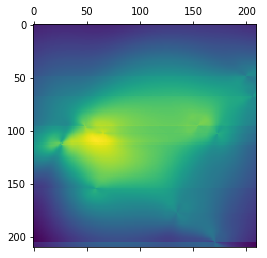

2315.8
1218
 11/300 [  3%] █                              ETA: 4303s

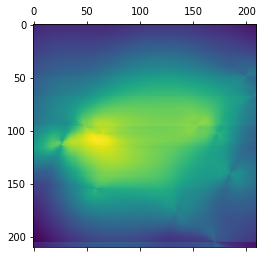

2315.8
1218
 12/300 [  4%] █                              ETA: 4292s

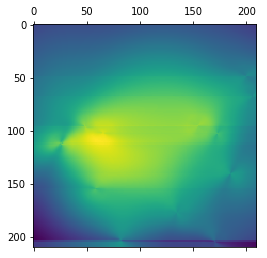

2337.0
1260
 13/300 [  4%] █                              ETA: 4281s

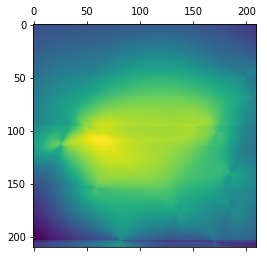

2337.1
1281
 14/300 [  4%] █                              ETA: 4268s

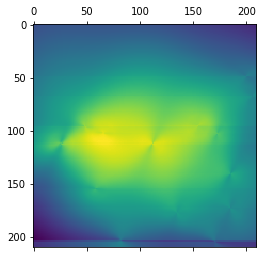

2337.7
1407
 15/300 [  5%] █                              ETA: 4251s

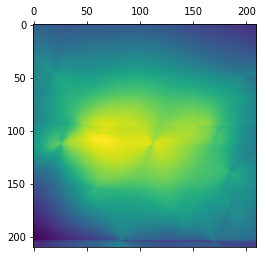

2337.7
1407
 16/300 [  5%] █                              ETA: 4241s

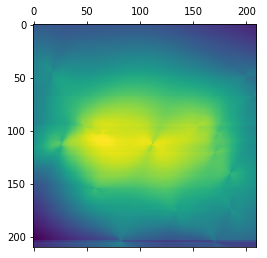

2337.8
1428
 17/300 [  5%] █                              ETA: 4218s

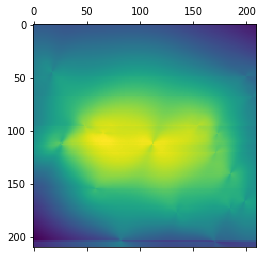

2337.9
1449
 18/300 [  6%] █                              ETA: 4203s

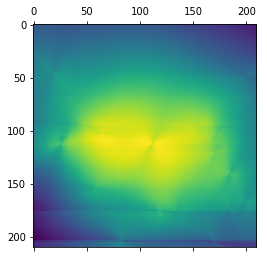

2341.6
2226
 19/300 [  6%] █                              ETA: 4180s

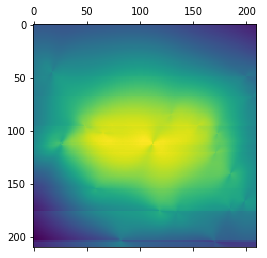

2341.2
2142
 20/300 [  6%] ██                             ETA: 4171s

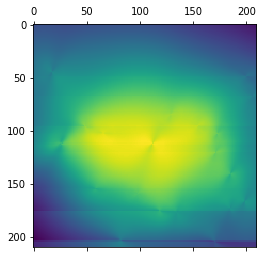

2341.2
2142
 21/300 [  7%] ██                             ETA: 4158s

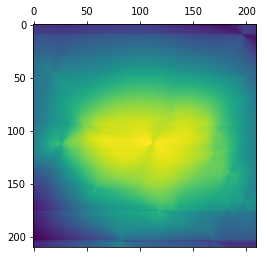

2341.6
2226
 22/300 [  7%] ██                             ETA: 4149s

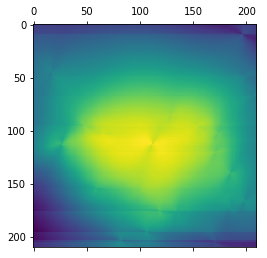

2341.5
2205
 23/300 [  7%] ██                             ETA: 4137s

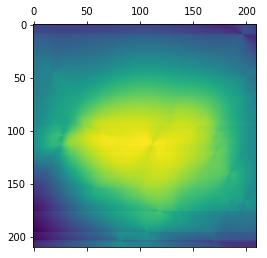

2341.2
2142
 24/300 [  8%] ██                             ETA: 4132s

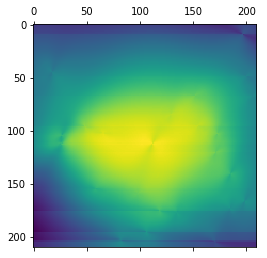

2341.2
2142
 25/300 [  8%] ██                             ETA: 4129s

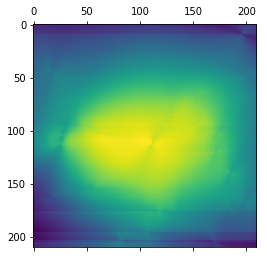

2341.2
2142
 26/300 [  8%] ██                             ETA: 4128s

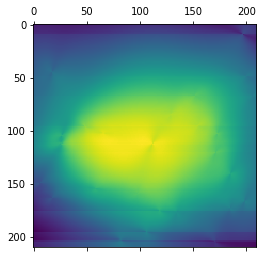

2341.2
2142
 27/300 [  9%] ██                             ETA: 4119s

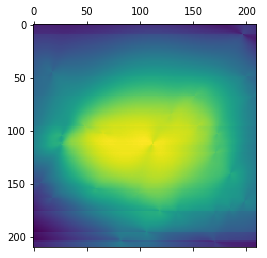

2341.2
2142
 28/300 [  9%] ██                             ETA: 4118s

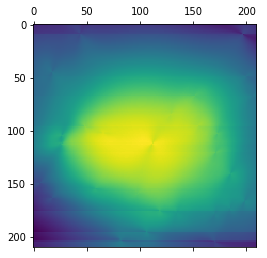

2341.2
2142
 29/300 [  9%] ██                             ETA: 4106s

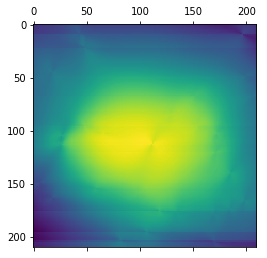

2341.2
2142
 30/300 [ 10%] ███                            ETA: 4088s

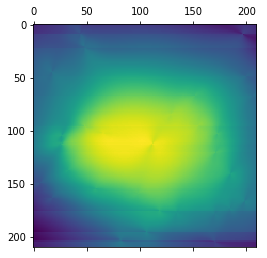

2341.1
2121
 31/300 [ 10%] ███                            ETA: 4073s

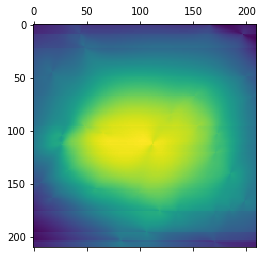

2341.1
2121
 32/300 [ 10%] ███                            ETA: 4064s

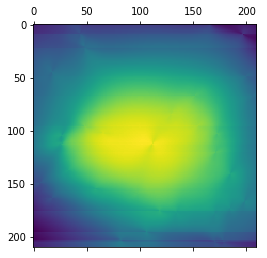

2341.2
2142
 33/300 [ 11%] ███                            ETA: 4059s

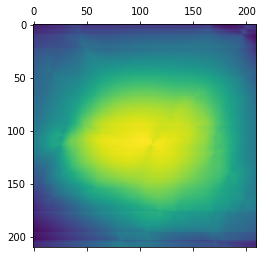

2341.2
2142
 34/300 [ 11%] ███                            ETA: 4061s

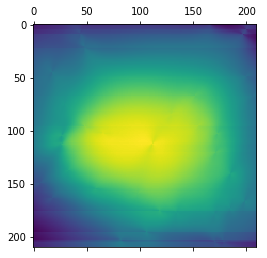

2341.2
2142
 35/300 [ 11%] ███                            ETA: 4045s

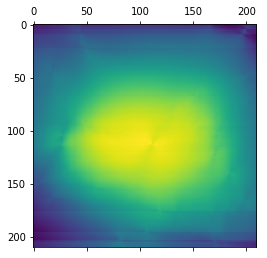

2341.2
2142
 36/300 [ 12%] ███                            ETA: 4028s

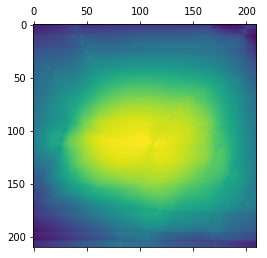

2341.2
2142
 37/300 [ 12%] ███                            ETA: 4003s

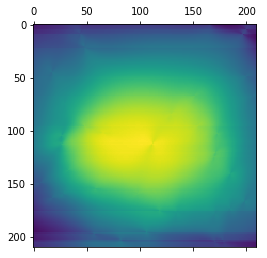

2341.1
2121
 38/300 [ 12%] ███                            ETA: 3975s

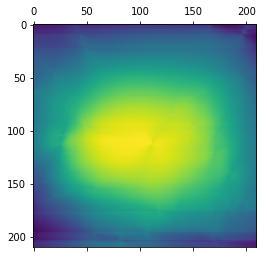

2341.1
2121
 39/300 [ 13%] ███                            ETA: 3949s

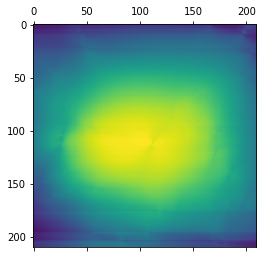

2341.1
2121
 40/300 [ 13%] ████                           ETA: 3933s

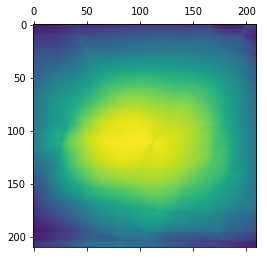

2341.1
2121
 41/300 [ 13%] ████                           ETA: 3917s

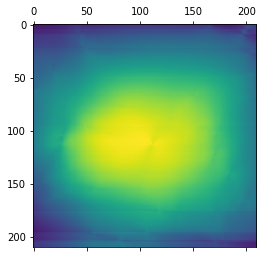

2341.1
2121
 42/300 [ 14%] ████                           ETA: 3900s

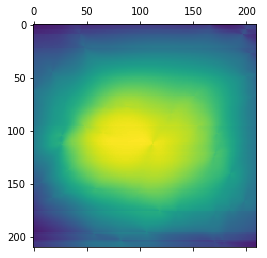

2341.1
2121
 43/300 [ 14%] ████                           ETA: 3885s

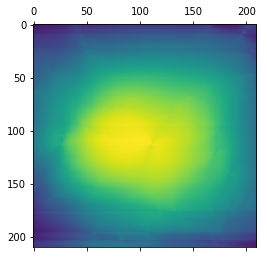

2341.1
2121
 44/300 [ 14%] ████                           ETA: 3866s

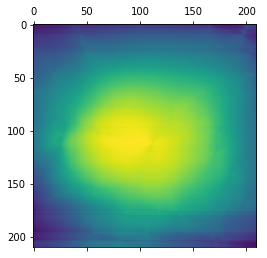

2341.1
2121
 45/300 [ 15%] ████                           ETA: 3851s

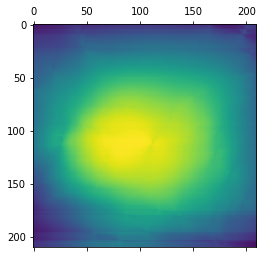

2341.1
2121
 46/300 [ 15%] ████                           ETA: 3830s

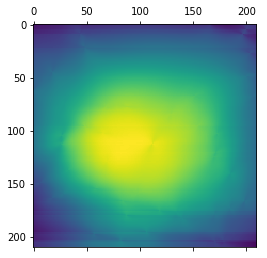

2381.8
1848
 47/300 [ 15%] ████                           ETA: 3808s

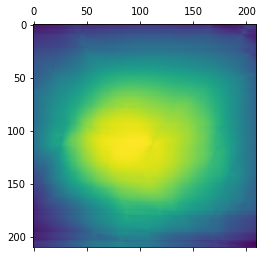

2382.3
1953
 48/300 [ 16%] ████                           ETA: 3789s

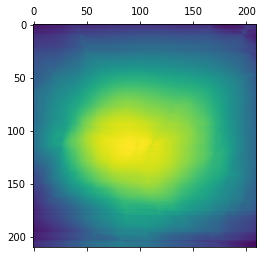

2381.9
1869
 49/300 [ 16%] ████                           ETA: 3774s

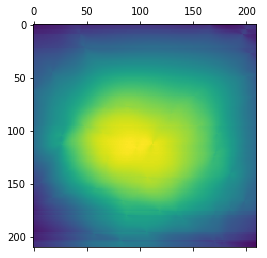

2382.1
1911
 50/300 [ 16%] █████                          ETA: 3760s

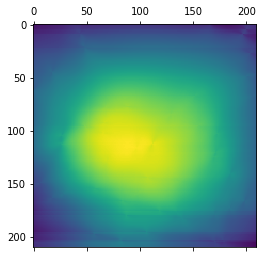

2381.7
1827
 51/300 [ 17%] █████                          ETA: 3749s

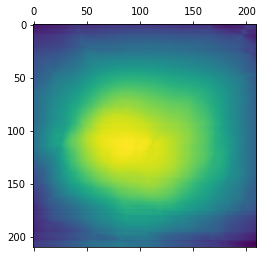

2381.7
1827
 52/300 [ 17%] █████                          ETA: 3734s

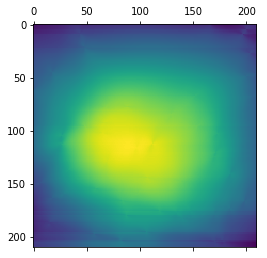

2381.7
1827
 53/300 [ 17%] █████                          ETA: 3720s

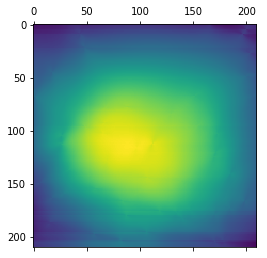

2381.7
1827
 54/300 [ 18%] █████                          ETA: 3704s

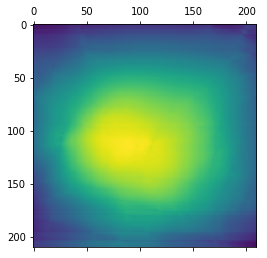

2381.7
1827
 55/300 [ 18%] █████                          ETA: 3689s

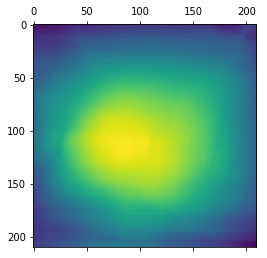

2381.7
1827
 56/300 [ 18%] █████                          ETA: 3674s

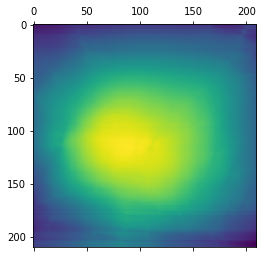

2381.7
1827
 57/300 [ 19%] █████                          ETA: 3666s

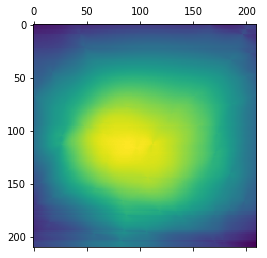

2381.7
1827
 58/300 [ 19%] █████                          ETA: 3652s

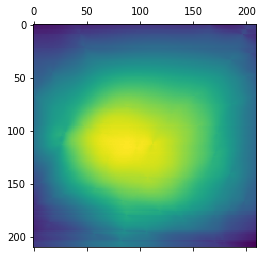

2381.7
1827
 59/300 [ 19%] █████                          ETA: 3642s

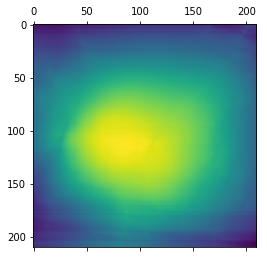

2381.7
1827
 60/300 [ 20%] ██████                         ETA: 3627s

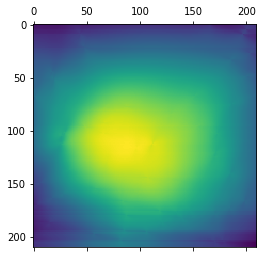

2381.7
1827
 61/300 [ 20%] ██████                         ETA: 3613s

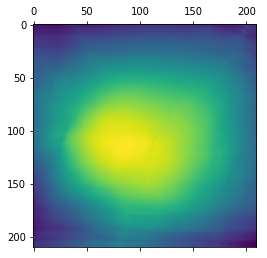

2444.7
1827
 62/300 [ 20%] ██████                         ETA: 3599s

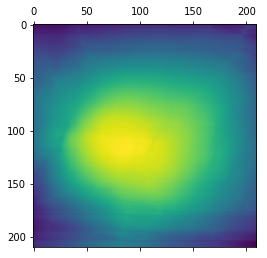

2444.6
1806
 63/300 [ 21%] ██████                         ETA: 3582s

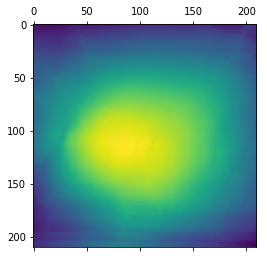

2444.7
1827
 64/300 [ 21%] ██████                         ETA: 3572s

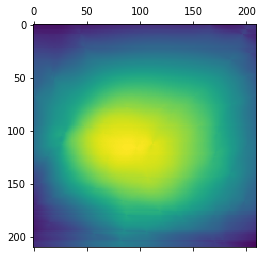

2444.7
1827
 65/300 [ 21%] ██████                         ETA: 3563s

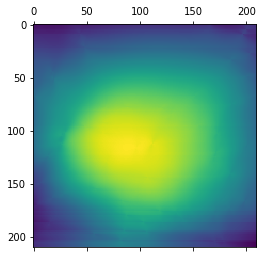

2444.8
1848
 66/300 [ 22%] ██████                         ETA: 3549s

KeyboardInterrupt: 

In [259]:
#i = 0
prob = np.zeros(grid_20.shape[0])
pbar = Progbar(300)
for i in range(300):
    pbar.update(i)
    # dis = (grid_glxy_l2diff(grid_20, all_sky_star[2][i][1:3])/4200.).astype(np.float32)
    dis = (grid_glxy_l2diff(grid_20, feed_dat_sel[i,0:2]*4200.)/4200.).astype(np.float32)
    dis = np.maximum(dis,0.05)
    #atan = grid_glxy_arctan(grid_20, all_sky_star[2][i][1:3])
    atan = grid_glxy_arctan(grid_20, feed_dat_sel[i,0:2]*4200.)
    #b2d = np.log(r_list[i].prob(dis.tolist()).eval())
    c2d = np.log(p_list[i].prob(atan.tolist()).eval()*dis**(-1.))
#    prob=prob+b2d
    prob=prob+c2d
    plt.clf()
#print(a.shape, b.shape)
    plt.matshow(prob)
#plt.savefig("what.pdf")
    plt.show()
    print((np.argmax(prob)/prob.shape[0])*21)
    print((np.argmax(prob)%prob.shape[0])*21)
print(all_sky_star[2][i][1:3])

[[-120.61593667 -120.57103321 -120.53301379 ..., -104.13617377
  -104.43950483 -104.80225396]
 [-116.49786863 -116.45385563 -116.4170123  ..., -107.55745032
  -107.88643929 -108.22507811]
 [-116.07415663 -116.03068146 -115.99467075 ..., -107.13569629
  -107.48840269 -107.83252907]
 ..., 
 [-108.44344211 -108.03395784 -107.62520322 ..., -120.3850065  -120.79067183
  -121.19917747]
 [-108.70181559 -108.29773408 -107.89439546 ..., -120.41135109 -120.8219903
  -121.23475759]
 [-108.96429066 -108.56527714 -108.16697213 ..., -120.39568489
  -120.81283665 -121.23137564]]


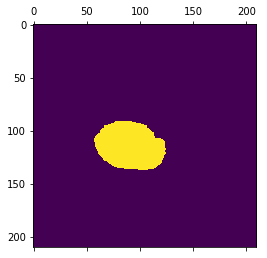

In [347]:
print(prob)
plt.matshow(prob>-30)
#plt.savefig("what.pdf")  
plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209


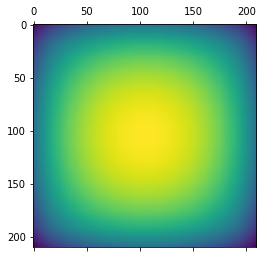

In [294]:
mask = np.zeros((210,210))
pbar = Progbar(mask.shape[0])
for i in range(mask.shape[0]):
    pbar.update(i)
    print(i)
    for j in range(mask.shape[0]):
        mask[i,j] = np.sum(1/np.maximum((grid_glxy_l2diff(grid_20, [10+i*20., 10+j*20.])/4200.),0.05).astype(np.float32))
    #print(mask[i,j])
plt.matshow(mask[:,:])
plt.show()

23362
2336.2
1092


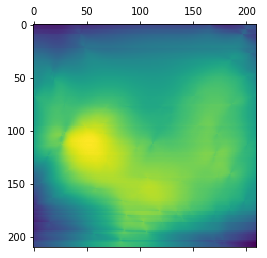

In [361]:
#print(np.max(prob),np.max(np.log(mask)))
#masked = prob*(mask)**
mask2 = mask**(10)
mask2 = mask2*(10**(-48))
#print(mask2)
masked = prob-0.01*mask2
plt.matshow(masked)

print(np.argmax(masked))
print((np.argmax(masked)/prob.shape[0])*21)
print((np.argmax(masked)%prob.shape[0])*21)
plt.show()

In [249]:
np.argmax([[1,2,],[3,4]])

3